In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import keras.models
import keras.layers
from keras.models import Sequential
from keras.layers import Activation, Dense

In [4]:
import numpy as np

In [6]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
dirsplit0 = "../20220408CAPSULE_DATA/splits/splitslowres/split_0/"

In [8]:
dirsplit1 = "../20220408CAPSULE_DATA/splits/splitslowres/split_1/"

In [9]:
#os.listdir(dirsplit0)

In [10]:
#os.listdir(dirsplit1)

In [9]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def MCC(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
'''
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

'''

"\ntrain_datagen = ImageDataGenerator(\n    rescale=1./255,\n    rotation_range=40,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    zoom_range=0.2,\n    shear_range=0.2,\n    horizontal_flip=True,\n    fill_mode='nearest'\n    )\n\n"

In [11]:
TRAINING_DIR = dirsplit1
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    target_size=(168, 168))

Found 24100 images belonging to 11 classes.


In [12]:
# No need to augment validation set
validation_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
VALIDATION_DIR = dirsplit0
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              class_mode='categorical',
                                                              target_size=(168, 168))

Found 23061 images belonging to 11 classes.


## ResNet152

In [29]:
#from tensorflow.keras.applications.resnet50 import ResNet50

In [14]:
from tensorflow.keras.applications.resnet import ResNet152

In [16]:
pre_trained_model = ResNet152(input_shape=(168,168,3),include_top =False, weights= 'imagenet')

In [17]:
for layer in pre_trained_model.layers:  
    layer.trainable=False

In [18]:
last_layer = pre_trained_model.get_layer('conv4_block6_out')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 11, 11, 1024)


In [19]:
x = keras.layers.Flatten()(last_output)

x = keras.layers.Dropout(0.4)(x)      

x = keras.layers.Dense(256, activation='relu')(x)

x = keras.layers.Dropout(0.2)(x)                  

x = keras.layers.Dense(11, activation='softmax')(x)           

model = keras.Model(pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=['acc',f1_m,precision_m, recall_m, MCC])


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 168, 168, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 174, 174, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 84, 84, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 84, 84, 64)   256         ['conv1_conv[0][0]']         

 conv2_block3_2_conv (Conv2D)   (None, 42, 42, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 42, 42, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 42, 42, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 42, 42, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 21, 21, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 21, 21, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 21, 21, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 21, 21, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block6_2_relu (Activatio  (None, 21, 21, 128)  0          ['conv3_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_3_conv (Conv2D)   (None, 21, 21, 512)  66048       ['conv3_block6_2_relu[0][0]']    
                                                                                                  
 conv3_block6_3_bn (BatchNormal  (None, 21, 21, 512)  2048       ['conv3_block6_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_add (Add)         (None, 21, 21, 512)  0           ['conv3_block5_out[0][0]',       
                                                                  'conv3_block6_3_bn[0][0]']      
          

                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 11, 11, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 11, 11, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 11, 11, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 11, 11, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 11, 11, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 11, 11, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
          

Total params: 41,441,163
Trainable params: 31,722,507
Non-trainable params: 9,718,656
__________________________________________________________________________________________________


In [21]:
history_resnet = model.fit(train_generator,
                              epochs=5,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/5


2022-04-28 22:56:55.676059: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


754/754 [==============================] - 260s 336ms/step - loss: 4.6406 - acc: 0.7358 - f1_m: 0.1560 - precision_m: 0.1918 - recall_m: 0.1394 - MCC: 0.1519 - val_loss: 1.7051 - val_acc: 0.6874 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_MCC: 0.0000e+00
Epoch 2/5
754/754 [==============================] - 244s 324ms/step - loss: 1.3527 - acc: 0.7670 - f1_m: 0.0090 - precision_m: 0.0090 - recall_m: 0.0090 - MCC: 0.0087 - val_loss: 1.3597 - val_acc: 0.6874 - val_f1_m: 0.6872 - val_precision_m: 0.6872 - val_recall_m: 0.6872 - val_MCC: 0.6559
Epoch 3/5
754/754 [==============================] - 249s 330ms/step - loss: 1.0933 - acc: 0.7670 - f1_m: 0.7670 - precision_m: 0.7670 - recall_m: 0.7670 - MCC: 0.7437 - val_loss: 1.2810 - val_acc: 0.6874 - val_f1_m: 0.6874 - val_precision_m: 0.6874 - val_recall_m: 0.6874 - val_MCC: 0.6561
Epoch 4/5
754/754 [==============================] - 249s 331ms/step - loss: 1.0171 - acc: 0.7670 - f1_m: 0.7664 - precis

In [22]:
# evaluate the model
loss, accuracy, f1_score, precision, recall, MCC = model.evaluate(train_generator, verbose=0)

In [24]:
print ("loss =",loss,"accuracy=",accuracy,"f1=",f1_score,"precision",precision,"recall",recall,"MCC",MCC)

loss = 0.9884508848190308 accuracy= 0.7670124769210815 f1= 0.7669926285743713 precision 0.7669926881790161 recall 0.7669926881790161 MCC 0.743691623210907


In [23]:
ac = history_resnet.history['acc']
v_ac = history_resnet.history['val_acc']   
lo = history_resnet.history['loss']
v_lo = history_resnet.history['val_loss']
f = history_resnet.history['f1_m']
v_f = history_resnet.history['val_f1_m']
epochs = history_resnet.epoch

Text(0, 0.5, 'Accuracy')

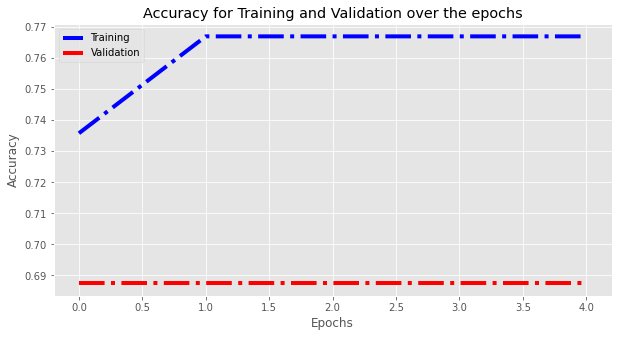

In [25]:
plt.figure(figsize=(10,5),frameon=False)
plt.plot(epochs,ac,c='b',ls='-.',lw='4',label='Training')
plt.plot(epochs,v_ac,c='r',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('Accuracy for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

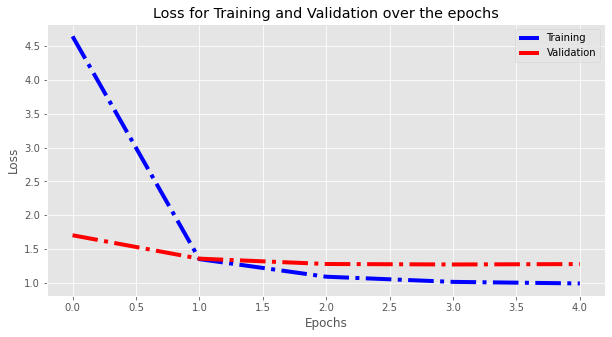

In [26]:
plt.figure(figsize=(10,5))
plt.plot(epochs,lo,c='b',ls='-.',lw='4',label='Training')
plt.plot(epochs,v_lo,c='r',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('Loss for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'f1')

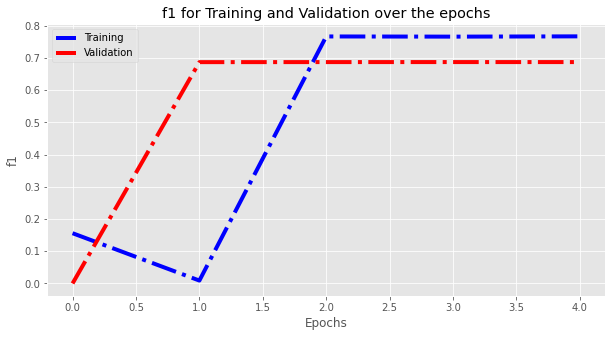

In [27]:
plt.figure(figsize=(10,5))
plt.plot(epochs,f,c='b',ls='-.',lw='4',label='Training')
plt.plot(epochs,v_f,c='r',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('f1 for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('f1')

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))
